In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as C
import astropy.units as U

import chic

from astropy.cosmology import Planck18
from scipy.integrate import quad

# Problem 1

## Part 2(c)

In [2]:
H0 = Planck18.H0
Om = Planck18.Om0
Or = Planck18.Ogamma0 * 1.68

print("Constants:")
print(f"    H_0 = {H0}")
print(f"Omega_m = {Om}")
print(f"Omega_r = {Or:.3e}")

a_eq = Or / Om
t_eq = 2 * (2 - np.sqrt(2)) / 3 * a_eq**2 / (H0 * np.sqrt(Or))
t_eq = t_eq.to(U.yr)

print()
print("Calculations:")
print(f"   a_eq = {a_eq:.3e}")
print(f"   t_eq = {t_eq:.3e}")

Constants:
    H_0 = 67.66 km / (Mpc s)
Omega_m = 0.30966
Omega_r = 9.075e-05

Calculations:
   a_eq = 2.931e-04
   t_eq = 5.089e+04 yr


## Part 3(b)

In [3]:
H0 = Planck18.H0
Om = Planck18.Om0
OL = Planck18.Ode0

print("Constants:")
print(f"    H_0 = {H0}")
print(f"Omega_m = {Om}")
print(f"Omega_L = {OL:.5f}")

a_mL = (Om / OL)**(1/3)
x = 1 / a_mL
t_0 = 2 / (3 * H0 * np.sqrt(OL)) * np.arcsinh(x ** (3/2))
t_0 = t_0.to(U.yr)

print()
print("Calculations:")
print(f"   a_mL = {a_mL:.3f}")
print(f"    t_0 = {t_0:.3e}")

Constants:
    H_0 = 67.66 km / (Mpc s)
Omega_m = 0.30966
Omega_L = 0.68885

Calculations:
   a_mL = 0.766
    t_0 = 1.381e+10 yr


## Part 4

In [4]:
def a(t):
    x = H0 * np.sqrt(OL) * t
    x = x.to(U.dimensionless_unscaled).value
    return a_mL * np.sinh(1.5 * x)**(2/3)

def integrand(t_in_yr):
    return 1 / a(t_in_yr * U.yr)

eta_0, err = quad(integrand, 0, t_0.value)
eta_0 = eta_0 * U.yr
print(f"eta_0 = {eta_0.to(U.Gyr):.1f}")
print(f"      = {(eta_0 * C.c).to(U.Mpc):.0f}")

eta_0 = 47.2 Gyr
      = 14459 Mpc


# Problem 2

## Part 2

$$
\eta(z) = H_0^{-1} \int_{0}^{1 / (1 + z)} 
\frac{
    \mathrm{d} a
}{
    a \sqrt{ \Omega_r a^{-2} + \Omega_m a^{-1} + \Omega_k a^{0} + \Omega_\Lambda a^{+2} } 
}
$$

$$
\implies \chi(z) = \eta(0) - \eta(z) = H_0^{-1} \int^{1}_{1 / (1 + z)} 
\frac{
    \mathrm{d} a
}{
    a \sqrt{ \Omega_r a^{-2} + \Omega_m a^{-1} + \Omega_k a^{0} + \Omega_\Lambda a^{+2} } 
}
$$

In [5]:
def chi(
    z,
    H0 = Planck18.H0,
    Or = Planck18.Ogamma0 * 1.68,
    Om = Planck18.Om0,
    Ok = Planck18.Ok0,
    OL = Planck18.Ode0,
):
    def H0_eta(z):
        def integrand(a):
            return np.pow(a**2 * (
                Or * a**-2
                + Om * a**-1
                + Ok
                + OL * a**2
            ), -0.5)
        return quad(integrand, 1 / (1 + z), 1)[0]

    return (C.c / H0).to(U.Gpc) * np.array([H0_eta(_z) for _z in np.atleast_1d(z)])

chi(0)

<Quantity [0.] Gpc>

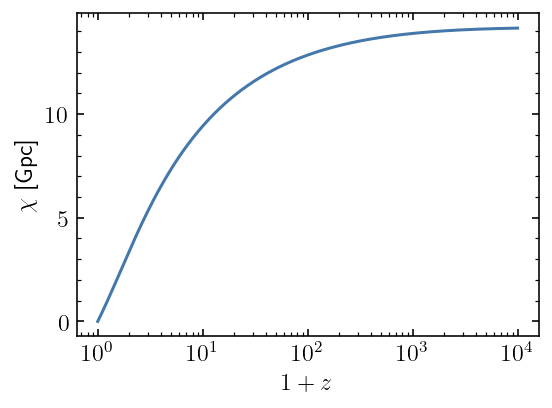

In [6]:
zs = np.geomspace(1, 1e4 + 1, 1_000) - 1
chis = chi(zs)

plt.figure(figsize=(4, 3))
plt.plot(1 + zs, chis)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel("$1 + z$")
plt.ylabel("$\\chi$ [Gpc]")
plt.tight_layout()
plt.show()

## Part 3

In [7]:
def S_k(chi, H0, Ok):
    alpha = (H0 * np.sqrt(np.abs(Ok)) / C.c).to(1 / U.Gpc)
    alpha_chi = (alpha * chi).to(U.dimensionless_unscaled).value
    
    if Ok < 0:    # k = +1
        return np.sin(alpha_chi) / alpha
    elif Ok > 0:  # k = -1
        return np.sinh(alpha_chi) / alpha
    else:         # k = 0
        return chi

def luminosity_distance(
    z,
    H0 = Planck18.H0,
    Or = Planck18.Ogamma0 * 1.68,
    Om = Planck18.Om0,
    Ok = Planck18.Ok0,
    OL = Planck18.Ode0,
):
    z_arr = np.atleast_1d(z)
    chi_arr = chi(z_arr, H0=H0, Or=Or, Om=Om, Ok=Ok, OL=OL)
    S_k_arr = S_k(chi_arr, H0, Ok)
    return S_k_arr * (1 + z_arr)

def ang_diameter_distance(
    z,
    H0 = Planck18.H0,
    Or = Planck18.Ogamma0 * 1.68,
    Om = Planck18.Om0,
    Ok = Planck18.Ok0,
    OL = Planck18.Ode0,
):
    z_arr = np.atleast_1d(z)
    chi_arr = chi(z_arr, H0=H0, Or=Or, Om=Om, Ok=Ok, OL=OL)
    S_k_arr = S_k(chi_arr, H0, Ok)
    return S_k_arr / (1 + z_arr)

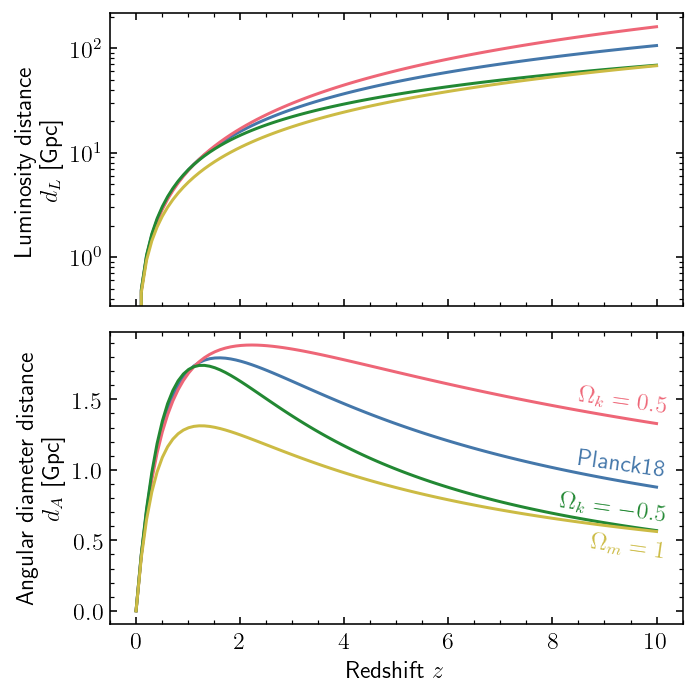

In [8]:
zs = np.linspace(0, 10, 100)

fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

for cosmo_kw in [
    dict(
        Ok = 0,
        H0 = Planck18.H0,
        Or = Planck18.Ogamma0 * 1.68,
        Om = Planck18.Om0,
        OL = Planck18.Ode0,
    ),
    dict(
        Ok = +0.5,
        H0 = Planck18.H0,
        Or = 0.5 * Planck18.Ogamma0 * 1.68,
        Om = 0.5 * Planck18.Om0,
        OL = 0.5 * Planck18.Ode0,
    ),
    dict(
        Ok = -0.5,
        H0 = Planck18.H0,
        Or = 1.5 * Planck18.Ogamma0 * 1.68,
        Om = 1.5 * Planck18.Om0,
        OL = 1.5 * Planck18.Ode0,
    ),
    dict(
        Ok = 0,
        H0 = Planck18.H0,
        Or = 0,
        Om = 1,
        OL = 0,
    ),
]:
    axs[0].plot(zs, luminosity_distance(zs, **cosmo_kw))
    axs[1].plot(zs, ang_diameter_distance(zs, **cosmo_kw))

axs[0].set_yscale('log')

axs[1].text(1 - 0.025, 0.49, "Planck18", color='C0',
            transform=axs[1].transAxes, ha='right', va='bottom', rotation=-8)
axs[1].text(1 - 0.025, 0.71, "$\\Omega_k = 0.5$", color='C1',
            transform=axs[1].transAxes, ha='right', va='bottom', rotation=-8)
axs[1].text(1 - 0.025, 0.34, "$\\Omega_k = -0.5$", color='C2',
            transform=axs[1].transAxes, ha='right', va='bottom', rotation=-8)
axs[1].text(1 - 0.025, 0.32, "$\\Omega_m = 1$", color='C3',
            transform=axs[1].transAxes, ha='right', va='top', rotation=-8)

axs[1].set_xlabel('Redshift $z$')

axs[0].set_ylabel('Luminosity distance\n$d_L$ [Gpc]')
axs[1].set_ylabel('Angular diameter distance\n$d_A$ [Gpc]')

fig.tight_layout()
plt.show()

## Part 4

$$
\begin{aligned}
F(z; \Omega_\Lambda)
&= (1+z) \int^{1}_{1 / (1 + z)} 
\frac{
    \mathrm{d} a
}{
    a \sqrt{ \Omega_m a^{-1} + \Omega_\Lambda a^{+2} } 
} \\
&= \frac{1+z}{a_{m \Lambda} \sqrt{\Omega_\Lambda}}
\int^{1/a_{m\Lambda}}_{1 / a_{m\Lambda}(1 + z)} 
\frac{\mathrm{d} x}{\sqrt{x + x^{4}}} \\
&= \frac{1+z}{\sqrt{\Omega_\Lambda}}
\Big[
    (1+z) {}_2 F_1 \big( \tfrac{1}{3}, \tfrac{1}{2}, \tfrac{4}{3}, -a_{m\Lambda}^3 (1+z)^3 \big)
    - {}_2 F_1 \big( \tfrac{1}{3}, \tfrac{1}{2}, \tfrac{4}{3}, -a_{m\Lambda}^3 \big)
\Big]
\end{aligned}
$$
integration performed with Mathematica

because we're assuming that radiation is irrelevant and $k = 0$, I think we assume that $\Omega_m + \Omega_\Lambda = 1$ and thus $a_{m \Lambda} = ((1 - \Omega_\Lambda) / \Omega_\Lambda)^{1/3}$.

In [9]:
from scipy.special import hyp2f1

def F(z, OL, Om=Planck18.Om0):
    a_mL = ((1 - OL) / OL)**(1/3)
    return (1 + z) * (
        (1 + z) * hyp2f1(1./3., 1./2., 4./3., -a_mL**3 * (1 + z)**3)
                - hyp2f1(1./3., 1./2., 4./3., -a_mL**3)
    ) / np.sqrt(OL)

I also tried doing the integral numerically and verified the above formula and implementation

that code, for posterity:

```python
def F_num(z, OL, Om=Planck18.Om0):
    a_mL = ((1 - OL) / OL)**(1/3)

    def integrand(x):
        return 1 / np.sqrt(x + x**4)

    integral = np.array([quad(integrand, 1 / (a_mL * (1 + z)), 1 / a_mL)[0] for z in np.atleast_1d(z)])
    return (1 + z) * integral / (a_mL * np.sqrt(OL))

rng = np.random.default_rng()
zs = rng.uniform(low=0, high=2, size=(10,))
OLs = rng.uniform(low=0, high=1, size=(10,))
for z in zs:
    for OL in OLs:
        print(f"{F(z, OL) - F_num(z, OL).squeeze():+.2e}, ", end="")
```

## Part 5(b)

the code below downloads the data as `data.txt` if it does not already exist in the current directory

In [10]:
![ ! -f data.txt ] && \
curl -o data.txt https://archive.stsci.edu/hlsps/ps1cosmo/scolnic/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_lcparam-full.txt

In [11]:
data = np.loadtxt(
    'data.txt',
    dtype={
        'names': ('name', 'zcmb', 'zhel', 'dz', 'mb', 'dmb'),
        'formats': ('S16', '<f8', '<f8', '<f8', '<f8', '<f8'),
    }
)

z_i = data['zcmb']
mu_i = data['mb']
sigma_i = data['dmb']

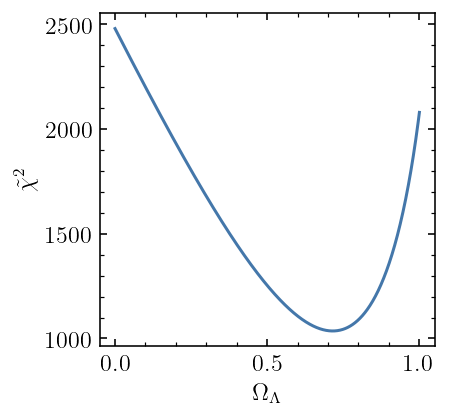

In [12]:
def chi_sq(OL):
    Delta_i = 5 * np.log10(F(z_i, OL)) - mu_i
    term1 = (sigma_i**-2 * Delta_i**2).sum()
    term2 = (sigma_i**-2 * Delta_i).sum()**2 / (sigma_i**-2).sum()
    return term1 - term2
        
OLs = np.linspace(0, 1, 1_000)[1:]
chi_sqs = np.array([chi_sq(OL) for OL in OLs])

plt.figure(figsize=(3, 3))
plt.plot(OLs, chi_sqs)
plt.xlabel('$\\Omega_{\\Lambda}$')
plt.ylabel('$\\tilde \\chi^2$')
plt.show()

In [13]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(chi_sq, bounds=(1e-10, 1))
if not res.success:
    raise RuntimeError("did not converge!" + res.message)

print(f"minimization result:")
print(f"  Omega_L = {res.x:.3f}")
print(f"   chi_sq = {res.fun:.2e}")

print()
print(f"Planck18 reference:")
print(f"  Omega_L = {Planck18.Ode0:.3f}")

minimization result:
  Omega_L = 0.715
   chi_sq = 1.04e+03

Planck18 reference:
  Omega_L = 0.689


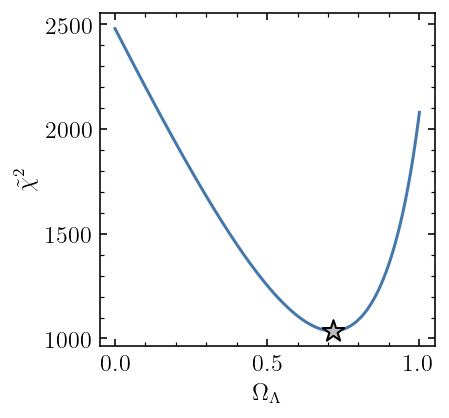

In [14]:
def chi_sq(OL):
    Delta_i = 5 * np.log10(F(z_i, OL)) - mu_i
    term1 = (sigma_i**-2 * Delta_i**2).sum()
    term2 = (sigma_i**-2 * Delta_i).sum()**2 / (sigma_i**-2).sum()
    return term1 - term2
        
OLs = np.linspace(0, 1, 1_000)[1:]
chi_sqs = np.array([chi_sq(OL) for OL in OLs])

plt.figure(figsize=(3, 3))
plt.plot(OLs, chi_sqs)
plt.scatter([res.x], [res.fun], marker='*', s=128, facecolor='C6', edgecolor='k', zorder=999)
plt.xlabel('$\\Omega_{\\Lambda}$')
plt.ylabel('$\\tilde \\chi^2$')
plt.show()